In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vegetable-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1817999%2F2965251%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T163656Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4d036e74164f0a09017c0610c24d726e59197307324ac1b60912a1d0fe730bc1ae0934243ac00c6bcd2dbb46c428ed1ba6adb03a3b0132ffd25e35fe0eb1eed498b3a2786f9ec2e8eff729b62d049b2c03e344c011f5e941c8fffb4734a5a4f6cedd2be9f6fe61baaca039b64b403bc395e44537621aa7b265fc9e77e16d2605c60bc1bcc6c4b824002e0392b8f606efd65040b585de2cbafbfa1ed49bc25501ebca0c207f7264a3e9d3b3c0180c784f18be56f39003cbe46bc18cd854fe100649e132218755feb3997cbed6b2c503103325ea94219807dca777352bd0b65889c204c1eac414dc36d4683a7adfa8611d8f0943716624683b2b0932b4e09c3f6d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 560031432 bytes downloaded
Downloaded and uncompressed: vegetable-image-dataset
Data source import complete.


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import os, shutil
import warnings
warnings.filterwarnings('ignore')

# Visualise the Images

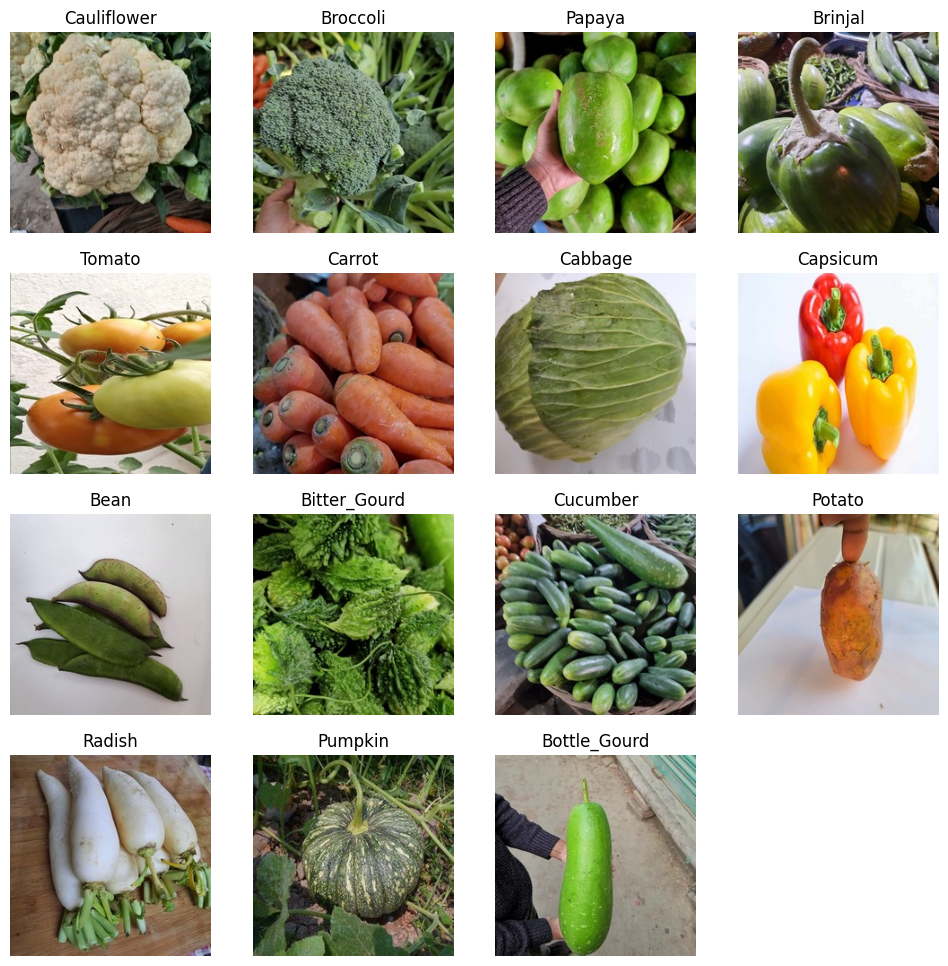

In [3]:
# Let's plot a few images
train_path = "../input/vegetable-image-dataset/Vegetable Images/train"
validation_path = "../input/vegetable-image-dataset/Vegetable Images/validation"
test_path = "../input/vegetable-image-dataset/Vegetable Images/test"

image_categories = os.listdir('../input/vegetable-image-dataset/Vegetable Images/train')

def plot_images(image_categories):

    # Create a figure
    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(image_categories):

        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0


        # Create Subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')

    plt.show()

# Call the function
plot_images(image_categories)


# Prepare the Dataset

In [4]:
# Creating Image Data Generator for train, validation and test set

# 1. Train Set
train_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
train_image_generator = train_gen.flow_from_directory(
                                            train_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

# 2. Validation Set
val_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
val_image_generator = train_gen.flow_from_directory(
                                            validation_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

# 3. Test Set
test_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
test_image_generator = train_gen.flow_from_directory(
                                            test_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [5]:
# Print the class encodings done by the generators
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


# Building a CNN model

In [6]:
# Build a custom sequential CNN model

model = Sequential() # model object

# Add Layers
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[150, 150, 3]))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))

# Flatten the feature map
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(15, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [7]:
# Compile and fit the model
early_stopping = keras.callbacks.EarlyStopping(patience=5) # Set up callbacks
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')
hist = model.fit(train_image_generator,
                 epochs=3,
                 verbose=1,
                 validation_data=val_image_generator,
                 steps_per_epoch = 15000//32,
                 validation_steps = 3000//32,
                 callbacks=early_stopping)

Epoch 1/3
468/468 [==============================] - 595s 1s/step - loss: 0.1010 - accuracy: 0.9672 - val_loss: 0.1856 - val_accuracy: 0.9533
Epoch 2/3
468/468 [==============================] - 692s 1s/step - loss: 0.0789 - accuracy: 0.9757 - val_loss: 0.2368 - val_accuracy: 0.9385
Epoch 3/3
468/468 [==============================] - 688s 1s/step - loss: 0.0752 - accuracy: 0.9770 - val_loss: 0.2091 - val_accuracy: 0.9516


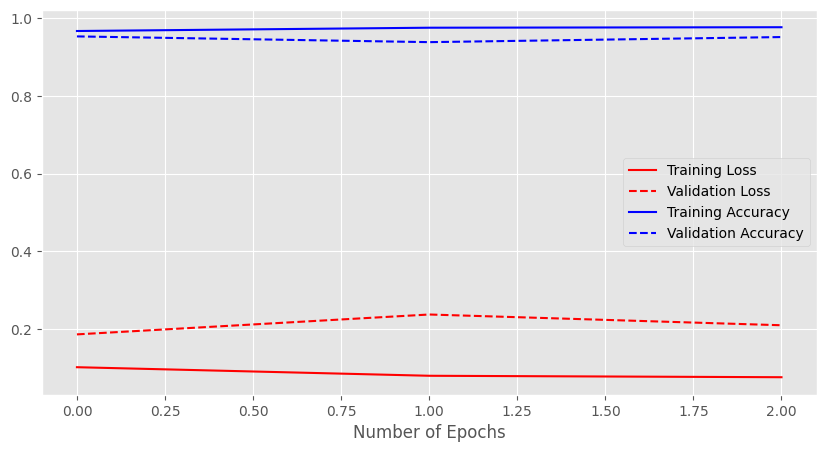

In [8]:
# Plot the error and accuracy
h = hist.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()